使用卷积变分自编码器生成MNIST数据
===

In [1]:
import time
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from jjzhk.progressbar import ProgressBar

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

# 1.全局设置

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)

# Hyperparameters
random_seed = 0
learning_rate = 0.001
num_epochs = 50
batch_size = 128

# Architecture
num_features = 784
num_latent = 15

Device: cuda:0


# 2.导入数据

In [3]:
train_dataset = datasets.MNIST(root='/input/', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='/input/', 
                              train=False, 
                              transform=transforms.ToTensor())

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

# 3.模型

In [4]:
class ConvVariationalAutoencoder(torch.nn.Module):
    def __init__(self, num_features, num_latent):
        super(ConvVariationalAutoencoder, self).__init__()
        
        ###############
        # ENCODER
        ##############
        
        # calculate same padding:
        # (w - k + 2*p)/s + 1 = o
        # => p = (s(o-1) - w + k)/2

        self.enc_conv_1 = torch.nn.Conv2d(in_channels=1,
                                          out_channels=16,
                                          kernel_size=(6, 6),
                                          stride=(2, 2),
                                          padding=0)

        self.enc_conv_2 = torch.nn.Conv2d(in_channels=16,
                                          out_channels=32,
                                          kernel_size=(4, 4),
                                          stride=(2, 2),
                                          padding=0)                 
        
        self.enc_conv_3 = torch.nn.Conv2d(in_channels=32,
                                          out_channels=64,
                                          kernel_size=(2, 2),
                                          stride=(2, 2),
                                          padding=0)                     
        
        self.z_mean = torch.nn.Linear(64*2*2, num_latent)
        # in the original paper (Kingma & Welling 2015, we use
        # have a z_mean and z_var, but the problem is that
        # the z_var can be negative, which would cause issues
        # in the log later. Hence we assume that latent vector
        # has a z_mean and z_log_var component, and when we need
        # the regular variance or std_dev, we simply use 
        # an exponential function
        self.z_log_var = torch.nn.Linear(64*2*2, num_latent)
        
        
        
        ###############
        # DECODER
        ##############
        
        self.dec_linear_1 = torch.nn.Linear(num_latent, 64*2*2)
               
        self.dec_deconv_1 = torch.nn.ConvTranspose2d(in_channels=64,
                                                     out_channels=32,
                                                     kernel_size=(2, 2),
                                                     stride=(2, 2),
                                                     padding=0)
                                 
        self.dec_deconv_2 = torch.nn.ConvTranspose2d(in_channels=32,
                                                     out_channels=16,
                                                     kernel_size=(4, 4),
                                                     stride=(3, 3),
                                                     padding=1)
        
        self.dec_deconv_3 = torch.nn.ConvTranspose2d(in_channels=16,
                                                     out_channels=1,
                                                     kernel_size=(6, 6),
                                                     stride=(3, 3),
                                                     padding=4)


    def reparameterize(self, z_mu, z_log_var):
        # Sample epsilon from standard normal distribution
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(device)
        # note that log(x^2) = 2*log(x); hence divide by 2 to get std_dev
        # i.e., std_dev = exp(log(std_dev^2)/2) = exp(log(var)/2)
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z
        
    def encoder(self, features):
        x = self.enc_conv_1(features)
        x = F.leaky_relu(x)
        #print('conv1 out:', x.size())
        
        x = self.enc_conv_2(x)
        x = F.leaky_relu(x)
        #print('conv2 out:', x.size())
        
        x = self.enc_conv_3(x)
        x = F.leaky_relu(x)
        #print('conv3 out:', x.size())
        
        z_mean = self.z_mean(x.view(-1, 64*2*2))
        z_log_var = self.z_log_var(x.view(-1, 64*2*2))
        encoded = self.reparameterize(z_mean, z_log_var)
        
        return z_mean, z_log_var, encoded
    
    def decoder(self, encoded):
        x = self.dec_linear_1(encoded)
        x = x.view(-1, 64, 2, 2)
        
        x = self.dec_deconv_1(x)
        x = F.leaky_relu(x)
        #print('deconv1 out:', x.size())
        
        x = self.dec_deconv_2(x)
        x = F.leaky_relu(x)
        #print('deconv2 out:', x.size())
        
        x = self.dec_deconv_3(x)
        x = F.leaky_relu(x)
        #print('deconv1 out:', x.size())
        
        decoded = torch.sigmoid(x)
        return decoded

    def forward(self, features):
        
        z_mean, z_log_var, encoded = self.encoder(features)
        decoded = self.decoder(encoded)
        
        return z_mean, z_log_var, encoded, decoded

    
torch.manual_seed(random_seed)
model = ConvVariationalAutoencoder(num_features,
                                   num_latent)
model = model.to(device)
    

##########################
### COST AND OPTIMIZER
##########################

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

# 4.训练

In [5]:
bar = ProgressBar(num_epochs, len(train_loader), "Loss:%.3f")
for epoch in range(1, num_epochs+1):
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        # don't need labels, only the images (features)
        features = features.to(device)

        ### FORWARD AND BACK PROP
        z_mean, z_log_var, encoded, decoded = model(features)

        # cost = reconstruction loss + Kullback-Leibler divergence
        kl_divergence = (0.5 * (z_mean**2 + 
                                torch.exp(z_log_var) - z_log_var - 1)).sum()
        pixelwise_bce = F.binary_cross_entropy(decoded, features, reduction='sum')
        cost = kl_divergence + pixelwise_bce
        
        optimizer.zero_grad()
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        bar.show(epoch, cost)

Epoch: 001/050 | Batch 000/469 | Cost: 70508.8125
Epoch: 001/050 | Batch 050/469 | Cost: 69360.6953
Epoch: 001/050 | Batch 100/469 | Cost: 41215.0508
Epoch: 001/050 | Batch 150/469 | Cost: 34571.1836
Epoch: 001/050 | Batch 200/469 | Cost: 28148.8906
Epoch: 001/050 | Batch 250/469 | Cost: 29165.8730
Epoch: 001/050 | Batch 300/469 | Cost: 27415.2422
Epoch: 001/050 | Batch 350/469 | Cost: 26411.8633
Epoch: 001/050 | Batch 400/469 | Cost: 25679.7363
Epoch: 001/050 | Batch 450/469 | Cost: 25555.1719
Time elapsed: 0.27 min
Epoch: 002/050 | Batch 000/469 | Cost: 25298.0137
Epoch: 002/050 | Batch 050/469 | Cost: 24202.4609
Epoch: 002/050 | Batch 100/469 | Cost: 24087.5508
Epoch: 002/050 | Batch 150/469 | Cost: 24263.3398
Epoch: 002/050 | Batch 200/469 | Cost: 24431.4570
Epoch: 002/050 | Batch 250/469 | Cost: 23245.6797
Epoch: 002/050 | Batch 300/469 | Cost: 23687.9844
Epoch: 002/050 | Batch 350/469 | Cost: 23421.9258
Epoch: 002/050 | Batch 400/469 | Cost: 22785.8223
Epoch: 002/050 | Batch 450/

Epoch: 016/050 | Batch 350/469 | Cost: 15142.7539
Epoch: 016/050 | Batch 400/469 | Cost: 14802.4600
Epoch: 016/050 | Batch 450/469 | Cost: 15924.6719
Time elapsed: 3.88 min
Epoch: 017/050 | Batch 000/469 | Cost: 15620.1055
Epoch: 017/050 | Batch 050/469 | Cost: 15165.5996
Epoch: 017/050 | Batch 100/469 | Cost: 15206.6875
Epoch: 017/050 | Batch 150/469 | Cost: 14939.1904
Epoch: 017/050 | Batch 200/469 | Cost: 15348.1182
Epoch: 017/050 | Batch 250/469 | Cost: 14863.6816
Epoch: 017/050 | Batch 300/469 | Cost: 15040.8770
Epoch: 017/050 | Batch 350/469 | Cost: 14478.1562
Epoch: 017/050 | Batch 400/469 | Cost: 15480.2334
Epoch: 017/050 | Batch 450/469 | Cost: 14816.1543
Time elapsed: 4.13 min
Epoch: 018/050 | Batch 000/469 | Cost: 15687.6260
Epoch: 018/050 | Batch 050/469 | Cost: 14937.3223
Epoch: 018/050 | Batch 100/469 | Cost: 14721.6924
Epoch: 018/050 | Batch 150/469 | Cost: 15272.1934
Epoch: 018/050 | Batch 200/469 | Cost: 15207.6426
Epoch: 018/050 | Batch 250/469 | Cost: 15126.4629
Epoc

Epoch: 032/050 | Batch 200/469 | Cost: 14629.9385
Epoch: 032/050 | Batch 250/469 | Cost: 14670.9941
Epoch: 032/050 | Batch 300/469 | Cost: 14101.1758
Epoch: 032/050 | Batch 350/469 | Cost: 14716.0322
Epoch: 032/050 | Batch 400/469 | Cost: 14875.6855
Epoch: 032/050 | Batch 450/469 | Cost: 14623.8984
Time elapsed: 7.85 min
Epoch: 033/050 | Batch 000/469 | Cost: 13787.9346
Epoch: 033/050 | Batch 050/469 | Cost: 14094.0947
Epoch: 033/050 | Batch 100/469 | Cost: 15175.4590
Epoch: 033/050 | Batch 150/469 | Cost: 14195.0977
Epoch: 033/050 | Batch 200/469 | Cost: 14914.4102
Epoch: 033/050 | Batch 250/469 | Cost: 14596.9307
Epoch: 033/050 | Batch 300/469 | Cost: 14482.5117
Epoch: 033/050 | Batch 350/469 | Cost: 14805.7764
Epoch: 033/050 | Batch 400/469 | Cost: 14134.6172
Epoch: 033/050 | Batch 450/469 | Cost: 14182.5283
Time elapsed: 8.10 min
Epoch: 034/050 | Batch 000/469 | Cost: 15292.5059
Epoch: 034/050 | Batch 050/469 | Cost: 14756.4521
Epoch: 034/050 | Batch 100/469 | Cost: 14666.1602
Epoc

Epoch: 048/050 | Batch 050/469 | Cost: 13800.4590
Epoch: 048/050 | Batch 100/469 | Cost: 14129.0781
Epoch: 048/050 | Batch 150/469 | Cost: 14319.4443
Epoch: 048/050 | Batch 200/469 | Cost: 14172.5352
Epoch: 048/050 | Batch 250/469 | Cost: 14187.5996
Epoch: 048/050 | Batch 300/469 | Cost: 14394.1865
Epoch: 048/050 | Batch 350/469 | Cost: 14110.5273
Epoch: 048/050 | Batch 400/469 | Cost: 14586.6289
Epoch: 048/050 | Batch 450/469 | Cost: 14148.7520
Time elapsed: 11.96 min
Epoch: 049/050 | Batch 000/469 | Cost: 14857.4229
Epoch: 049/050 | Batch 050/469 | Cost: 14778.4473
Epoch: 049/050 | Batch 100/469 | Cost: 14469.3789
Epoch: 049/050 | Batch 150/469 | Cost: 13870.4863
Epoch: 049/050 | Batch 200/469 | Cost: 14389.0723
Epoch: 049/050 | Batch 250/469 | Cost: 14385.0254
Epoch: 049/050 | Batch 300/469 | Cost: 14264.1445
Epoch: 049/050 | Batch 350/469 | Cost: 14492.9316
Epoch: 049/050 | Batch 400/469 | Cost: 14077.8027
Epoch: 049/050 | Batch 450/469 | Cost: 14163.9277
Time elapsed: 12.22 min
Ep

# 5.评估

## 5.1.重构

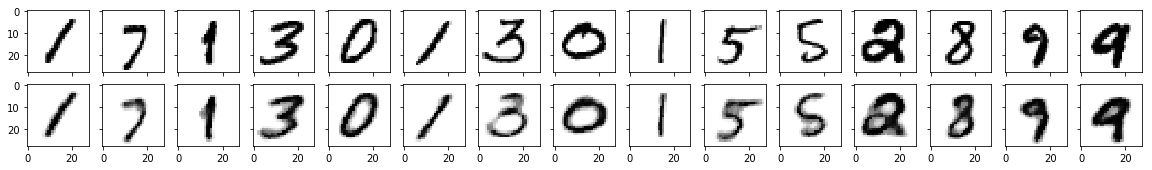

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

n_images = 15
image_width = 28

fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = features[:n_images]
decoded_images = decoded[:n_images]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        ax[i].imshow(img[i].detach().to(torch.device('cpu')).reshape((image_width, image_width)), cmap='binary')

## 5.2.生成

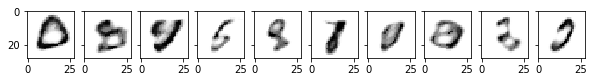

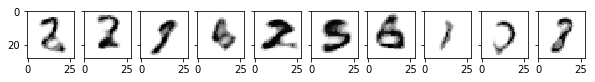

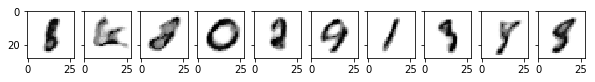

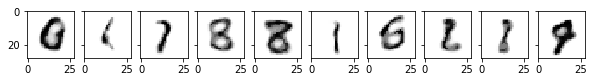

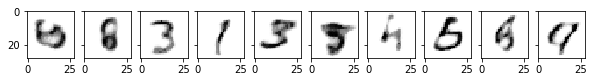

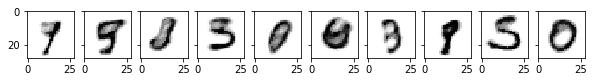

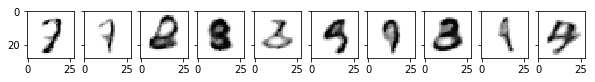

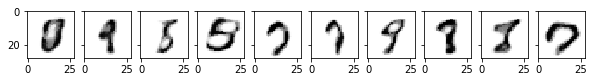

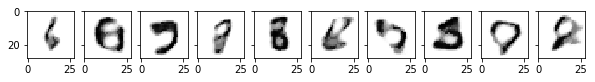

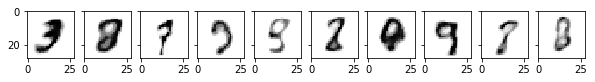

In [7]:
for i in range(10):

    ##########################
    ### RANDOM SAMPLE
    ##########################    
    
    n_images = 10
    rand_features = torch.randn(n_images, num_latent).to(device)
    new_images = model.decoder(rand_features)

    ##########################
    ### VISUALIZATION
    ##########################

    image_width = 28

    fig, axes = plt.subplots(nrows=1, ncols=n_images, figsize=(10, 2.5), sharey=True)
    decoded_images = new_images[:n_images]

    for ax, img in zip(axes, decoded_images):
        ax.imshow(img.detach().to(torch.device('cpu')).reshape((image_width, image_width)), cmap='binary')